<a href="https://colab.research.google.com/github/ebeltyukova/Neural-Network-/blob/main/Liza_cogs181_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

#### Instructions: run the “set up”, then skip all the way to the bottom and just run the “dataset preprocessing”, and then run the part labeled functions 2-4. i was planning seeing the results and based on the best performing model, adjust layers to make it even better. i can still write code for that tho, i just can't run it

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
import optuna

from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-03-21 22:57:01.295104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 22:57:01.295160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 22:57:01.296482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 22:57:01.304777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

2025-03-21 22:57:07.235708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


In [3]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))

    return image,label

In [4]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)


Train size: 50000
Test size: 10000


In [5]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

# **AlexNet model with relu function. Unchanged**

In [6]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')


])

/home/khraghuvanshi/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [8]:
history=model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)


Epoch 1/5


2025-03-21 22:57:13.335973: I external/local_xla/xla/service/service.cc:168] XLA service 0x562746393dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-21 22:57:13.336084: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-03-21 22:57:13.454677: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-21 22:57:13.988544: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


  24/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0851 - loss: 2.9766  

I0000 00:00:1742597838.737776   25126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.1932 - loss: 2.3736 - val_accuracy: 0.4262 - val_loss: 1.5929
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3671 - loss: 1.7476 - val_accuracy: 0.4827 - val_loss: 1.4322
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4424 - loss: 1.5516 - val_accuracy: 0.5220 - val_loss: 1.3236
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.4891 - loss: 1.4331 - val_accuracy: 0.5498 - val_loss: 1.2426
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5257 - loss: 1.3163 - val_accuracy: 0.5722 - val_loss: 1.1834


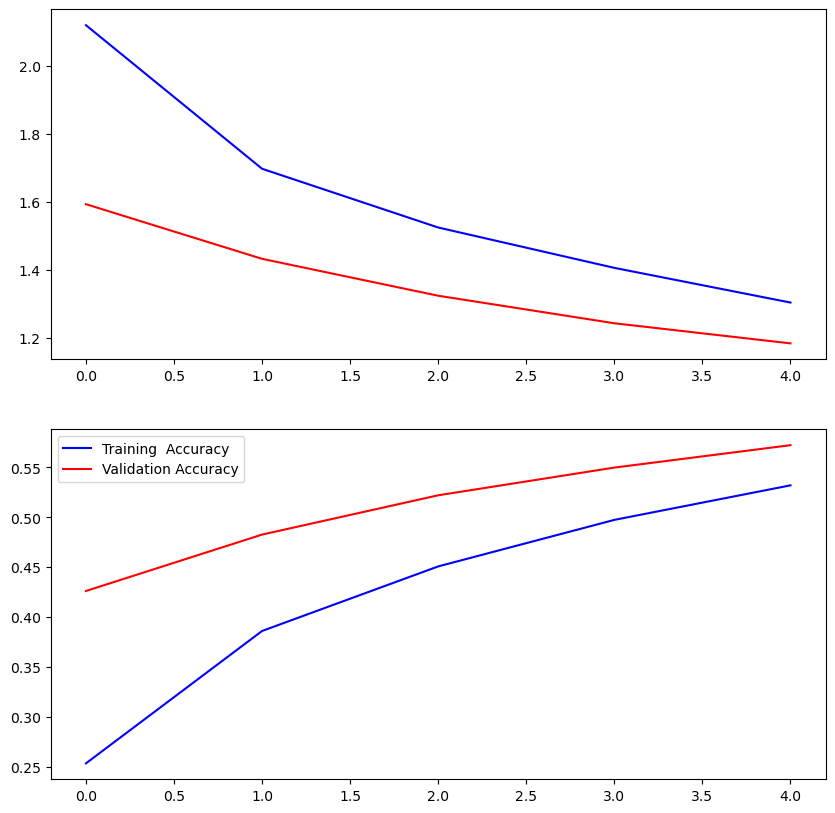

In [9]:
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# **AlexNet: ELU function**

In [10]:


model1=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='elu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')


])

In [11]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [12]:
history=model1.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.2542 - loss: 2.3223 - val_accuracy: 0.5000 - val_loss: 1.3934
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4343 - loss: 1.6015 - val_accuracy: 0.5607 - val_loss: 1.2371
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5105 - loss: 1.3810 - val_accuracy: 0.5874 - val_loss: 1.1656
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5671 - loss: 1.2278 - val_accuracy: 0.6183 - val_loss: 1.0903
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6031 - loss: 1.1222 - val_accuracy: 0.6299 - val_loss: 1.0464


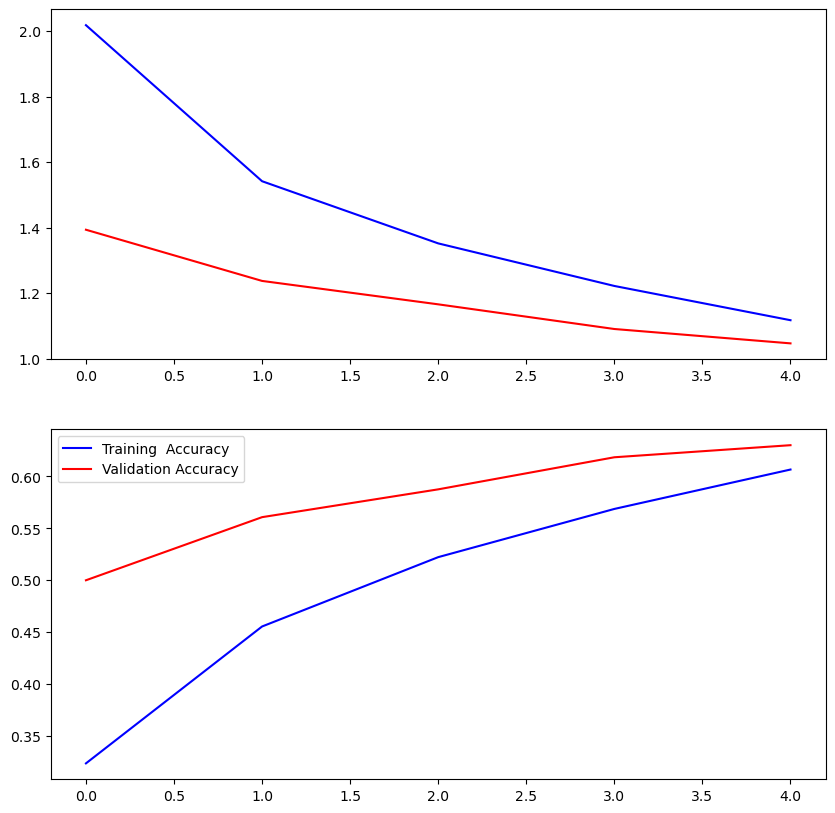

In [13]:
f,ax=plt.subplots(2,1,figsize=(10,10))

ax[0].plot(model1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model1.history.history['val_loss'],color='r',label='Validation Loss')

ax[1].plot(model1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model1.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# AlexNet: Leaky RELU

In [14]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), input_shape=(64,64,3)),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same"),
keras.layers.LeakyReLU(alpha=0.3),
keras.layers.BatchNormalization(),
keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same"),
keras.layers.LeakyReLU(alpha=0.3),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(pool_size=(2,2)),
keras.layers.Flatten(),
keras.layers.Dense(1024),
keras.layers.LeakyReLU(alpha=0.3),
keras.layers.Dropout(0.5),
keras.layers.Dense(1024),
keras.layers.LeakyReLU(alpha=0.3),
keras.layers.Dropout(0.5),
keras.layers.Dense(10, activation='softmax')
])

/home/khraghuvanshi/.local/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [16]:
history=model2.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2414 - loss: 2.2581 - val_accuracy: 0.4860 - val_loss: 1.4414
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4310 - loss: 1.5933 - val_accuracy: 0.5371 - val_loss: 1.2934
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5036 - loss: 1.3980 - val_accuracy: 0.5737 - val_loss: 1.2050
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5466 - loss: 1.2731 - val_accuracy: 0.5955 - val_loss: 1.1359
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5872 - loss: 1.1662 - val_accuracy: 0.6123 - val_loss: 1.0922


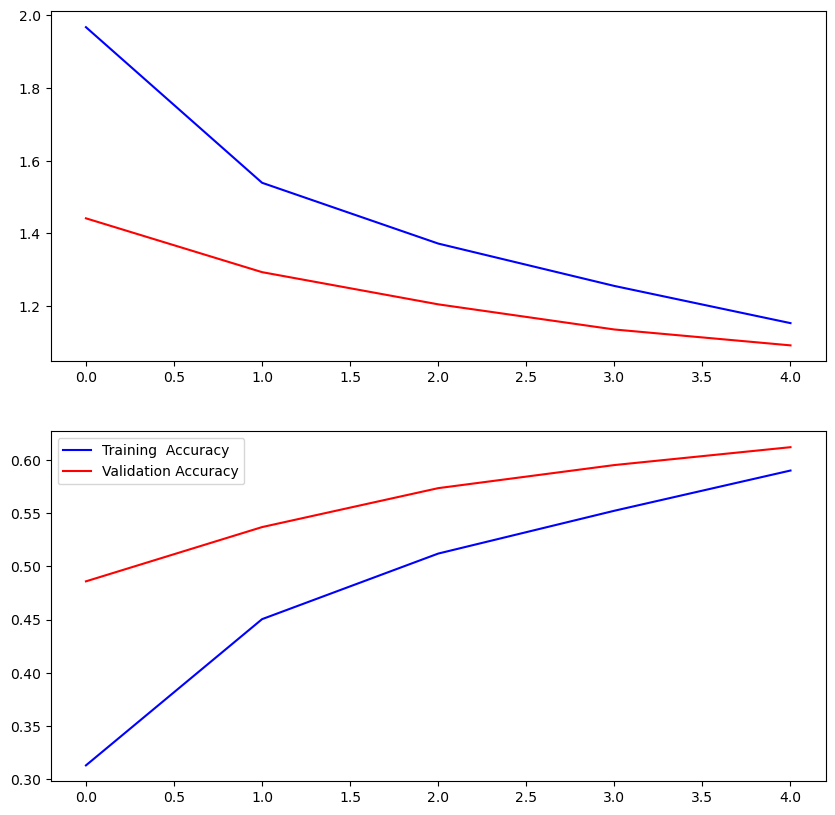

In [17]:
f,ax=plt.subplots(2,1,figsize=(10,10))


ax[0].plot(model2.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model2.history.history['val_loss'],color='r',label='Validation Loss')


ax[1].plot(model2.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model2.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# AlexNet: ELU (best performing) with Average Pooling

In [18]:
# average pooling

model3=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='elu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')


])


In [19]:
model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 7, 7, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 2, 2, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 1, 1, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [20]:
history=model3.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2746 - loss: 2.0109 - val_accuracy: 0.4371 - val_loss: 1.6014
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.3901 - loss: 1.7057 - val_accuracy: 0.4673 - val_loss: 1.5034
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4300 - loss: 1.5901 - val_accuracy: 0.4702 - val_loss: 1.4583
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4498 - loss: 1.5236 - val_accuracy: 0.5081 - val_loss: 1.3754
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4743 - loss: 1.4742 - val_accuracy: 0.5206 - val_loss: 1.3327


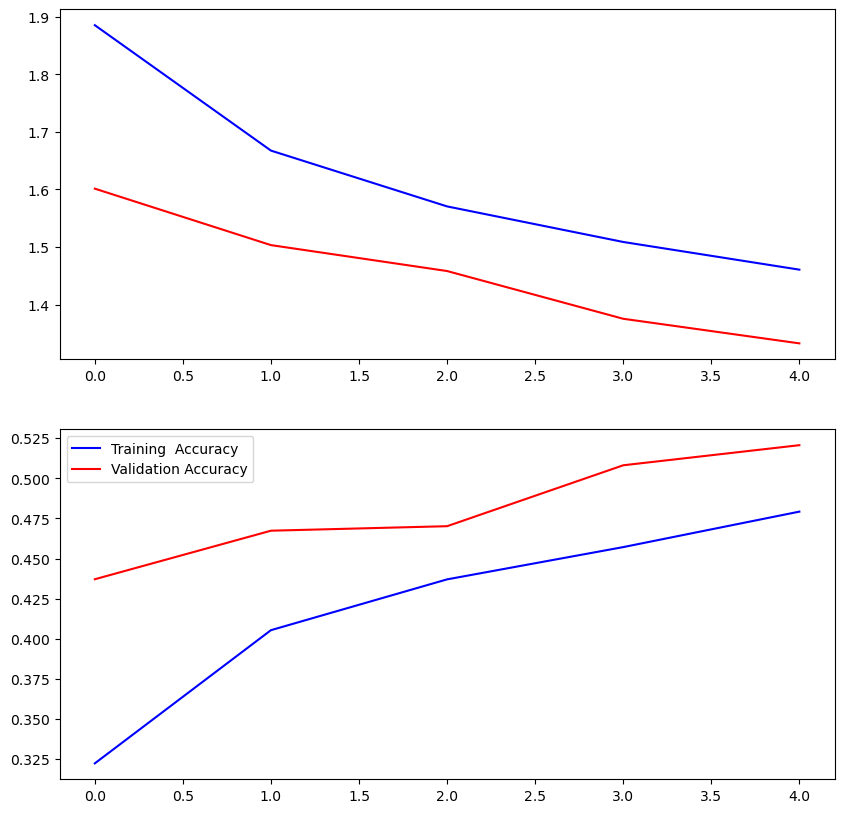

In [21]:
f,ax=plt.subplots(2,1,figsize=(10,10))

ax[0].plot(model3.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model3.history.history['val_loss'],color='r',label='Validation Loss')

ax[1].plot(model3.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model3.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# Testing hyperparameters using a function (AlexNet)

### Dataset preprocessing

In [22]:
# redefine dataset without pre set batching so we can test different batching parameters

train_ds2=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds2=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

In [23]:
train_ds_size2=tf.data.experimental.cardinality(train_ds2).numpy()
test_ds_size2=tf.data.experimental.cardinality(test_ds2).numpy()
print('Train size:',train_ds_size2)
print('Test size:',test_ds_size2)

Train size: 50000
Test size: 10000


In [24]:
train_ds2=(train_ds2
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)

         )
test_ds2=(test_ds2
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)

         )

### Function 1: Testing parameters for ELU activation function

In [25]:
from tensorflow.keras import regularizers

def create_model(learning_rate, weight_decay):
    model = keras.models.Sequential([
        keras.layers.Conv2D(128, (11,11), strides=(4,4), activation='elu',
                            input_shape=(64,64,3), kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(256, (5,5), activation='elu', padding="same",
                            kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((3,3)),
        keras.layers.Conv2D(256, (3,3), activation='elu', padding="same",
                            kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (1,1), activation='elu', padding="same",
                            kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (1,1), activation='elu', padding="same",
                            kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1024, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [26]:
import optuna

def objective(trial):

    # Hyperparameters to test
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create model and dataset
    model = create_model(learning_rate, weight_decay)
    train_batched = train_ds2.batch(batch_size)
    test_batched = test_ds2.batch(batch_size)

    # Train
    history = model.fit(
        train_batched,
        epochs=5,
        validation_data=test_batched,
        verbose=0
    )

    # Return best validation accuracy
    return max(history.history['val_accuracy'])


In [27]:
# Run optimization using optuna (adapts to find best hyperparameters)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)  # Test 5 combinations

[I 2025-03-21 23:02:43,703] A new study created in memory with name: no-name-ea986fc9-80a7-484a-ba6f-e13549d0d39d
[I 2025-03-21 23:04:10,937] Trial 0 finished with value: 0.6865000128746033 and parameters: {'learning_rate': 0.016833436819393654, 'weight_decay': 0.00030592500736575945, 'batch_size': 32}. Best is trial 0 with value: 0.6865000128746033.
[I 2025-03-21 23:05:36,919] Trial 1 finished with value: 0.5019999742507935 and parameters: {'learning_rate': 0.00010669713686601924, 'weight_decay': 1.0800071816322815e-05, 'batch_size': 32}. Best is trial 0 with value: 0.6865000128746033.
[I 2025-03-21 23:07:03,275] Trial 2 finished with value: 0.6643000245094299 and parameters: {'learning_rate': 0.00797304866595499, 'weight_decay': 0.00344613173647827, 'batch_size': 32}. Best is trial 0 with value: 0.6865000128746033.
[I 2025-03-21 23:08:29,165] Trial 3 finished with value: 0.673799991607666 and parameters: {'learning_rate': 0.0036639634607214546, 'weight_decay': 3.8601037931567736e-05,

In [28]:
print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

Best Parameters: {'learning_rate': 0.016833436819393654, 'weight_decay': 0.00030592500736575945, 'batch_size': 32}
Best Validation Accuracy: 0.6865000128746033


### Function 2: testing more parameters for ELU

In [29]:
def create_model(learning_rate, num_filters1, num_filters2, fc_size, dropout_rate, weight_decay):
    model = Sequential([
        layers.Conv2D(num_filters1, (3, 3), activation='elu', padding='same',
                      input_shape=(64,64,3), kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(num_filters2, (3, 3), activation='elu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(num_filters2, (3, 3), activation='elu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Flatten(),
        layers.Dense(fc_size, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(dropout_rate),
        layers.Dense(fc_size, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [30]:
def objective(trial):
    # Suggested hyperparameters
    params = {
        'num_filters1': trial.suggest_categorical("num_filters1", [32, 64, 128]),
        'num_filters2': trial.suggest_categorical("num_filters2", [64, 128, 256]),
        'fc_size': trial.suggest_categorical("fc_size", [128, 256, 512]),
        'dropout_rate': trial.suggest_float("dropout_rate", 0.2, 0.5),
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True),
    }

    # Batch size is handled separately
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Create model
    model = create_model(**params)

    # Batch datasets dynamically based on batch size
    train_batched = train_ds2.batch(batch_size)
    test_batched = test_ds2.batch(batch_size)

    # Train model
    history = model.fit(
        train_batched,
        epochs=5,
        validation_data=test_batched,
        verbose=0
    )

    # Return the best validation accuracy
    return max(history.history['val_accuracy'])

In [31]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Print best trial details
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-21 23:09:56,121] A new study created in memory with name: no-name-fdc708e4-3adf-4fba-bd9e-58dcf9036a79
W0000 00:00:1742598604.782102   25123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742598618.022757   25126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742598620.576661   25128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742598622.528531   25128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
[I 2025-03-21 23:11:10,884] Trial 0 finished with value: 0.4223000109195709 and parameters: {'num_filters1': 64, 'num_filters2': 64, 'fc_size': 128, 'dropout_rate': 0.256712720639945, 'learning_rate': 0.00011471132510235758, 'weight_decay': 0.00015279791741648524, 'batch_size': 64}. Best is trial 0 with value: 0.4223000109195709.
W0000 00:00:1742598680.503906   25128 graph_launch.cc:

Best trial:
  Value:  0.670199990272522
  Params: 
    num_filters1: 64
    num_filters2: 256
    fc_size: 256
    dropout_rate: 0.20523275108059835
    learning_rate: 0.003095954009484188
    weight_decay: 0.0002679042641326641
    batch_size: 64


### Function 3: testing parameters for RELU

In [32]:
def create_model(learning_rate, num_filters1, num_filters2, fc_size, dropout_rate, weight_decay):
    model = Sequential([
        layers.Conv2D(num_filters1, (3, 3), activation='relu', padding='same',
                      input_shape=(64,64,3), kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(num_filters2, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(num_filters2, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Flatten(),
        layers.Dense(fc_size, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(dropout_rate),
        layers.Dense(fc_size, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


In [33]:
def objective(trial):
    # Suggested hyperparameters
    params = {
        'num_filters1': trial.suggest_categorical("num_filters1", [32, 64, 128]),
        'num_filters2': trial.suggest_categorical("num_filters2", [64, 128, 256]),
        'fc_size': trial.suggest_categorical("fc_size", [128, 256, 512]),
        'dropout_rate': trial.suggest_float("dropout_rate", 0.2, 0.5),
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True),
    }

    # Batch size is handled separately
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Create model
    model = create_model(**params)

    # Batch datasets dynamically based on batch size
    train_batched = train_ds2.batch(batch_size)
    test_batched = test_ds2.batch(batch_size)

    # Train model
    history = model.fit(
        train_batched,
        epochs=5,
        validation_data=test_batched,
        verbose=0
    )

    # Return the best validation accuracy
    return max(history.history['val_accuracy'])

In [34]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Print best trial details
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-21 23:19:08,694] A new study created in memory with name: no-name-47ba66ad-6c7c-444b-94a1-3a868203825f
W0000 00:00:1742599157.801533   25127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742599169.360986   25126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742599171.456070   25126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742599173.016082   25126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
[I 2025-03-21 23:20:14,295] Trial 0 finished with value: 0.6542999744415283 and parameters: {'num_filters1': 32, 'num_filters2': 64, 'fc_size': 512, 'dropout_rate': 0.39671184240296054, 'learning_rate': 0.009756756743183949, 'weight_decay': 0.0003332950506383974, 'batch_size': 64}. Best is trial 0 with value: 0.6542999744415283.
W0000 00:00:1742599223.368811   25127 graph_launch.cc:6

Best trial:
  Value:  0.6542999744415283
  Params: 
    num_filters1: 32
    num_filters2: 64
    fc_size: 512
    dropout_rate: 0.39671184240296054
    learning_rate: 0.009756756743183949
    weight_decay: 0.0003332950506383974
    batch_size: 64


### Function 4: Testing parameters for Leaky RELU

In [35]:

def create_model(learning_rate, num_filters1, num_filters2, fc_size, dropout_rate, weight_decay):
    model = Sequential([
        # Conv Block 1
        layers.Conv2D(num_filters1, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay),
                     input_shape=(64,64,3)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        # Conv Block 2
        layers.Conv2D(num_filters2, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        # Conv Block 3
        layers.Conv2D(num_filters2, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(fc_size, kernel_regularizer=regularizers.l2(weight_decay)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.Dropout(dropout_rate),
        layers.Dense(fc_size, kernel_regularizer=regularizers.l2(weight_decay)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model


In [36]:
def objective(trial):
    # Suggested hyperparameters
    params = {
        'num_filters1': trial.suggest_categorical("num_filters1", [32, 64, 128]),
        'num_filters2': trial.suggest_categorical("num_filters2", [64, 128, 256]),
        'fc_size': trial.suggest_categorical("fc_size", [128, 256, 512]),
        'dropout_rate': trial.suggest_float("dropout_rate", 0.2, 0.5),
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True),
    }

    # Batch size is handled separately
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Create model
    model = create_model(**params)

    # Batch datasets dynamically based on batch size
    train_batched = train_ds2.batch(batch_size)
    test_batched = test_ds2.batch(batch_size)

    # Train model
    history = model.fit(
        train_batched,
        epochs=5,
        validation_data=test_batched,
        verbose=0
    )

    # Return the best validation accuracy
    return max(history.history['val_accuracy'])

In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Print best trial details
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-21 23:26:15,905] A new study created in memory with name: no-name-b9fda4e3-52b2-4812-8df8-a7b27f2c6189
W0000 00:00:1742599596.574196   25126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742599599.941192   25126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
[I 2025-03-21 23:27:21,161] Trial 0 finished with value: 0.6388000249862671 and parameters: {'num_filters1': 64, 'num_filters2': 64, 'fc_size': 512, 'dropout_rate': 0.2836312805317127, 'learning_rate': 0.005917188616304649, 'weight_decay': 6.895268663613456e-05, 'batch_size': 128}. Best is trial 0 with value: 0.6388000249862671.
W0000 00:00:1742599649.955369   25128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742599665.006743   25127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1742599667.219966   25128 graph_launch.cc:6

Best trial:
  Value:  0.6581000089645386
  Params: 
    num_filters1: 128
    num_filters2: 128
    fc_size: 256
    dropout_rate: 0.2789824709475732
    learning_rate: 0.005361799945245844
    weight_decay: 0.00031061142643348913
    batch_size: 64


## Best model based on hyperparameter testing on AlexNet foundation:

### RELU

In [38]:
import keras

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4032242323158577),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4032242323158577),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0044522240320112915, decay=0.0002558087871946986)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/home/khraghuvanshi/.local/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [39]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_90 (Conv2D)              │ (None, 14, 14, 32)     │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 7, 7, 128)      │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 2, 2, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 2, 2, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,274 (1.26 MB)

 Trainable params: 330,186 (1.26 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [40]:
history=model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.1684 - loss: 2.4772 - val_accuracy: 0.3678 - val_loss: 1.8082
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2900 - loss: 1.9478 - val_accuracy: 0.4332 - val_loss: 1.6239
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.3478 - loss: 1.7993 - val_accuracy: 0.4648 - val_loss: 1.5146
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.3933 - loss: 1.6839 - val_accuracy: 0.4927 - val_loss: 1.4363
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4243 - loss: 1.6054 - val_accuracy: 0.5121 - val_loss: 1.3738


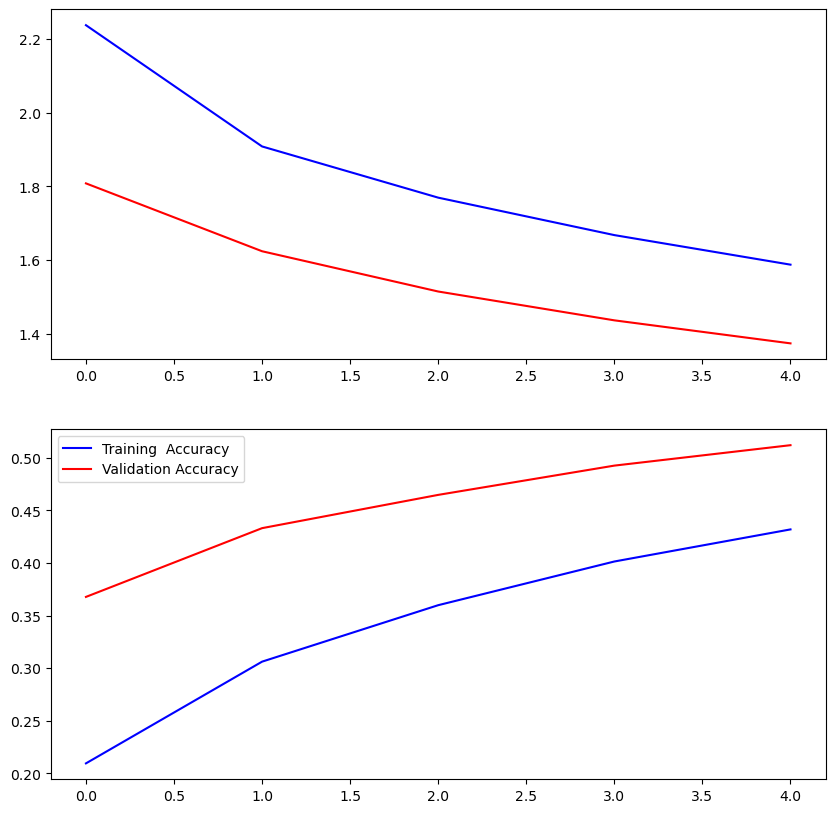

In [41]:
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

## ELU

In [42]:
import keras

model1 = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='elu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dropout(0.2856796034846101),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dropout(0.2856796034846101),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0007576232094249071, decay=6.633938833535347e-05)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [43]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model1.summary()


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_95 (Conv2D)              │ (None, 14, 14, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,643,018 (6.27 MB)

 Trainable params: 1,640,714 (6.26 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [44]:
history=model1.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.2950 - loss: 2.1021 - val_accuracy: 0.5114 - val_loss: 1.3843
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4728 - loss: 1.4988 - val_accuracy: 0.5639 - val_loss: 1.2409
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5266 - loss: 1.3390 - val_accuracy: 0.5942 - val_loss: 1.1578
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5701 - loss: 1.2196 - val_accuracy: 0.6099 - val_loss: 1.1190
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6099 - loss: 1.1218 - val_accuracy: 0.6342 - val_loss: 1.0609


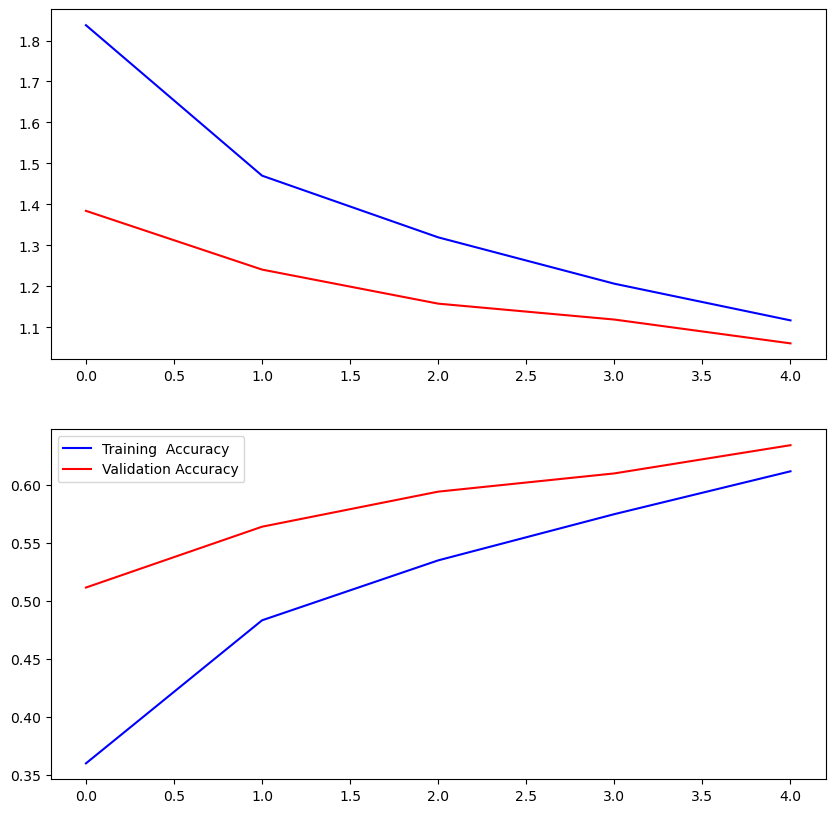

In [45]:
f,ax=plt.subplots(2,1,figsize=(10,10))

ax[0].plot(model1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model1.history.history['val_loss'],color='r',label='Validation Loss')

ax[1].plot(model1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model1.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


## Leaky Relu

In [46]:
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 2, 2, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [47]:
history=model2.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6162 - loss: 1.0786 - val_accuracy: 0.6376 - val_loss: 1.0280
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6492 - loss: 0.9935 - val_accuracy: 0.6442 - val_loss: 1.0038
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6696 - loss: 0.9344 - val_accuracy: 0.6575 - val_loss: 0.9632
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6921 - loss: 0.8778 - val_accuracy: 0.6653 - val_loss: 0.9567
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7129 - loss: 0.8179 - val_accuracy: 0.6752 - val_loss: 0.9443


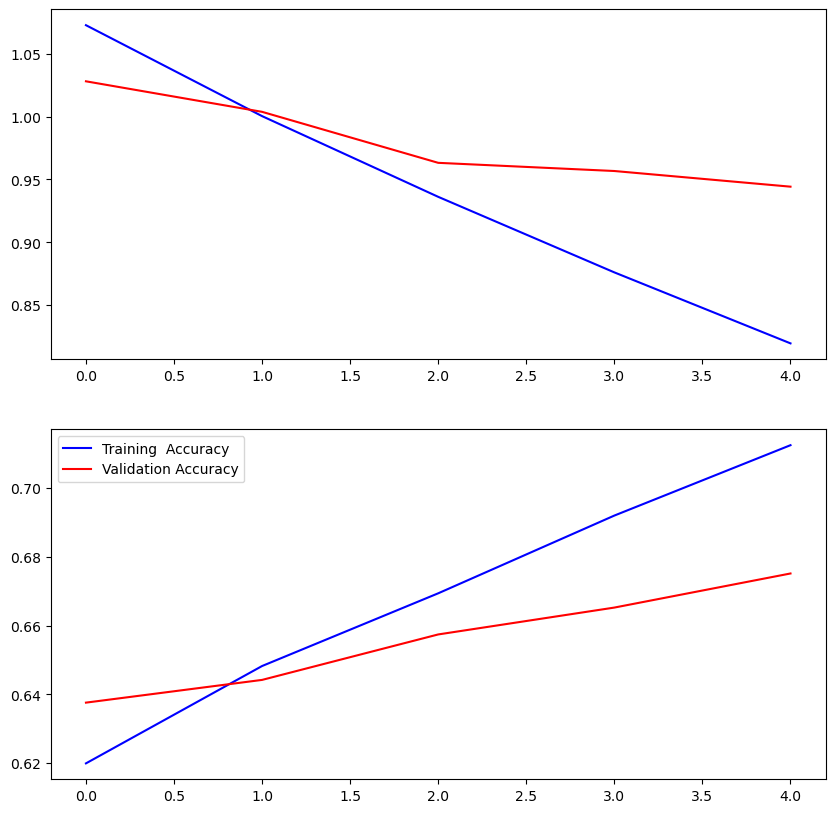

In [48]:
f,ax=plt.subplots(2,1,figsize=(10,10))


ax[0].plot(model2.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model2.history.history['val_loss'],color='r',label='Validation Loss')


ax[1].plot(model2.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model2.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()
